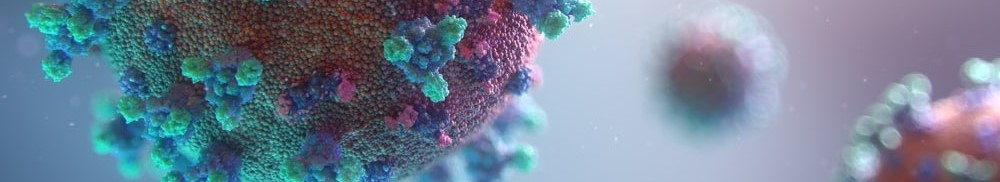

In [68]:
from IPython.display import Image
Image(filename =r"C:\Users\aarzo\Downloads\photo.jpg")


 <h1 style="text-align: center"> Noval Corona Virus (COVID-19) Visualization and Prediction </h1>

### What is COVID-19 ?
#### COVID-19 is the infectious disease caused by the most recently discovered coronavirus. This new virus and disease were unknown before the outbreak began in Wuhan, China, in December 2019. COVID-19 is now a pandemic affecting many countries globally.



# Importing required libraries

In [72]:
import pandas as pd      # used for data analysis
import numpy as np       # for large multi-dimensional array and matrix processing
import matplotlib.pyplot as plt   # used for data visualization 
%matplotlib inline
import seaborn as sns    # used for statistical graphics
import warnings
warnings.filterwarnings('ignore')
!pip install plotly
import plotly.express as px   # used in data visualizaton for plotting graphs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge,Lasso    # sklearn used for ML algorithms 
import datetime as dt    # module for working with date and time operation
from datetime import timedelta
from pmdarima import auto_arima

You should consider upgrading via the 'c:\users\aarzo\appdata\local\programs\python\python37-32\python.exe -m pip install --upgrade pip' command.


## Importing Data

In [73]:
covid = pd.read_csv("covid_19_india_new.csv")
covid.head()
covid.head(-10)

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...,...,...
9276,9277,09/12/20,8:00 AM,Manipur,-,-,23166,311,26396
9277,9278,09/12/20,8:00 AM,Meghalaya,-,-,11686,122,12410
9278,9279,09/12/20,8:00 AM,Mizoram,-,-,3772,6,3977
9279,9280,09/12/20,8:00 AM,Nagaland,-,-,10781,67,11479


## Getting size of the dataset

In [74]:
covid.shape

(9291, 9)

In [75]:
covid.describe()

,Sno,Cured,Deaths,Confirmed
count,9291.000000,9291.000000,9291.000000,9291.000000
mean,4646.000000,78632.660209,1487.620385,91839.783554
std,2682.225009,193110.228333,4713.813690,216601.368266
min,1.000000,0.000000,0.000000,0.000000
25%,2323.500000,152.000000,2.000000,538.500000
50%,4646.000000,4308.000000,66.000000,6832.000000
75%,6968.500000,57726.500000,926.500000,78856.000000
max,9291.000000,1737080.000000,47827.000000,1859367.000000


## Checking for null values

In [76]:
covid.isnull().sum()

Sno                         0
Date                        0
Time                        0
State/UnionTerritory        0
ConfirmedIndianNational     0
ConfirmedForeignNational    0
Cured                       0
Deaths                      0
Confirmed                   0
dtype: int64

In [77]:
# SNo is not required and 'Province/State' has too many missing values
#covid.drop(['SNo'],1,inplace=True)

In [78]:
covid.head().style.background_gradient(cmap='Reds')

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


## Checking for datatypes

In [79]:
covid.dtypes

Sno                          int64
Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [80]:
# Converting 'ObservationDate' into Datetime format
covid["Date"]= pd.to_datetime(covid["Date"])

In [81]:
grouped_country=covid.groupby(["State/UnionTerritory", "Date"]).agg({"Confirmed" : 'sum', "Cured" : 'sum', "Deaths" : 'sum'})

In [82]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Cured"]-grouped_country["Deaths"]
grouped_country["log-confirmed"]= np.log(grouped_country["Confirmed"])
grouped_country["log-active"]= np.log(grouped_country["Active Cases"])

## Data visualization

### In Data visualization, we will be focusing on two different analysis
<h4>
1. Datewise Analysis
2. Countrywise Analysis</h4>

## Datewise analysis

In [83]:
# Grouping all Cases with respect to dates
datewise=covid.groupby(["Date"]).agg({"Confirmed":'sum',"Cured":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [84]:
print("Basic Information about Covid-19 :")
print("Totol number of states with Disease Spread: ",len(covid["State/UnionTerritory"].unique()))
print("Total number of Confirmed Cases around the India: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the India: ",datewise["Cured"].iloc[-1])
print("Total number of Deaths Cases around the India: ",datewise["Deaths"].iloc[-1])

Basic Information about Covid-19 :
Totol number of states with Disease Spread:  45
Total number of Confirmed Cases around the India:  8683916
Total number of Recovered Cases around the India:  8066501
Total number of Deaths Cases around the India:  128121


In [85]:
# Plotting all Active Cases
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Cured"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [86]:
# Growth of Cases Weekly
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_cured=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_cured.append(datewise[datewise["WeekOfYear"]==i]["Cured"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_cured,
                    mode='lines+markers',
                    name='Weekly Growth of Cured Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

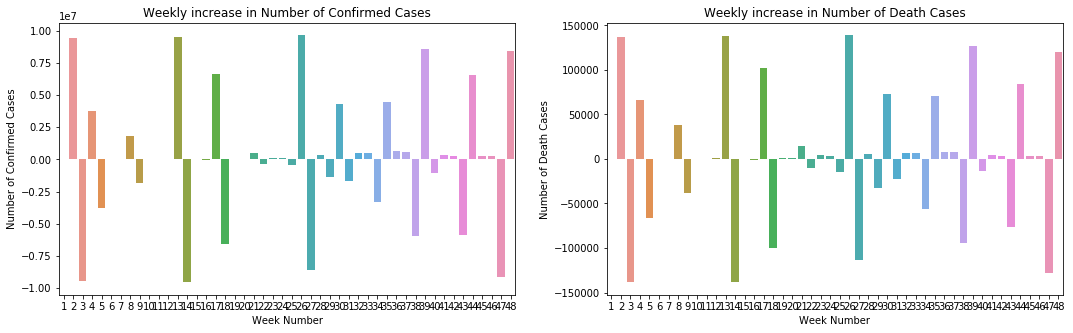

In [87]:
# Weekly increase of Confirmed and Death Cases
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

## Moratality Rate and Recovery Rate analysis 

#### Mortality Rate = (Number of Death Cases / Number of Confirmed Cases) x 100
#### Recovery Rate = (Number of Recoverd Cases / Number of Confirmed Cases) x 100

In [88]:
# Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Cured Rate"]=(datewise["Cured"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Cured"]-datewise["Cured"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Cured"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Cured Rate"].mean())
print("Median Recovery Rate",datewise["Cured Rate"].median())

# Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Cured Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Cured"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 1.9343182456803074
Median Mortality Rate 1.8435126445897687
Average Recovery Rate 51.64518709872462
Median Recovery Rate 60.80794058443813


<h4> From the graphs its observed that Mortality rate is increasing and Recovery Rate has started to increase in large numbers.</h4>

In [89]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Cured"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Cured"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  27568.0
Average increase in number of Recovered Cases every day:  25608.0
Average increase in number of Deaths Cases every day:  407.0


In [90]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Cured"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Growth Factor

<h4>Growth factor is the factor by which a quantity multiplies itself over time. </h4>
<h4>Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.<br>

A growth factor above 1 indicates an increase correspoding cases.<br>

A growth factor above 1 but trending downward is a positive sign, whereas a growth factor constantly above 1 is the sign of exponential growth.<br>

A growth factor constant at 1 indicates there is no change in any kind of cases.</h4><br>

In [91]:
# Growth Factor
print("Average growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["Cured"]/datewise["Cured"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["Cured"]/datewise["Cured"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Cured"]/datewise["Cured"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  10.351323416441279
Median growth factor of number of Confirmed Cases:  1.0518322291641726
Average growth factor of number of Recovered Cases:  inf
Median growth factor of number of Recovered Cases:  1.075752451809266
Average growth factor of number of Death Cases:  inf
Median growth factor of number of Death Cases:  1.0436046511627908


In [92]:
# Datewise Growth Factor
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["Confirmed"]-datewise["Cured"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Cured"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Cured"]+datewise["Deaths"])/(datewise["Cured"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

## Statewise Analysis

In [93]:
#Calculating countrywise 
countrywise=covid[covid["Date"]==covid["Date"].max()].groupby(["State/UnionTerritory"]).agg({"Confirmed":'sum',"Cured":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)

In [94]:
country_last_24_confirmed=[]
country_last_24_cured=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_cured.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Cured"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [95]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_cured,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 States with Highest Number of Death Cases in Last 24 Hours')

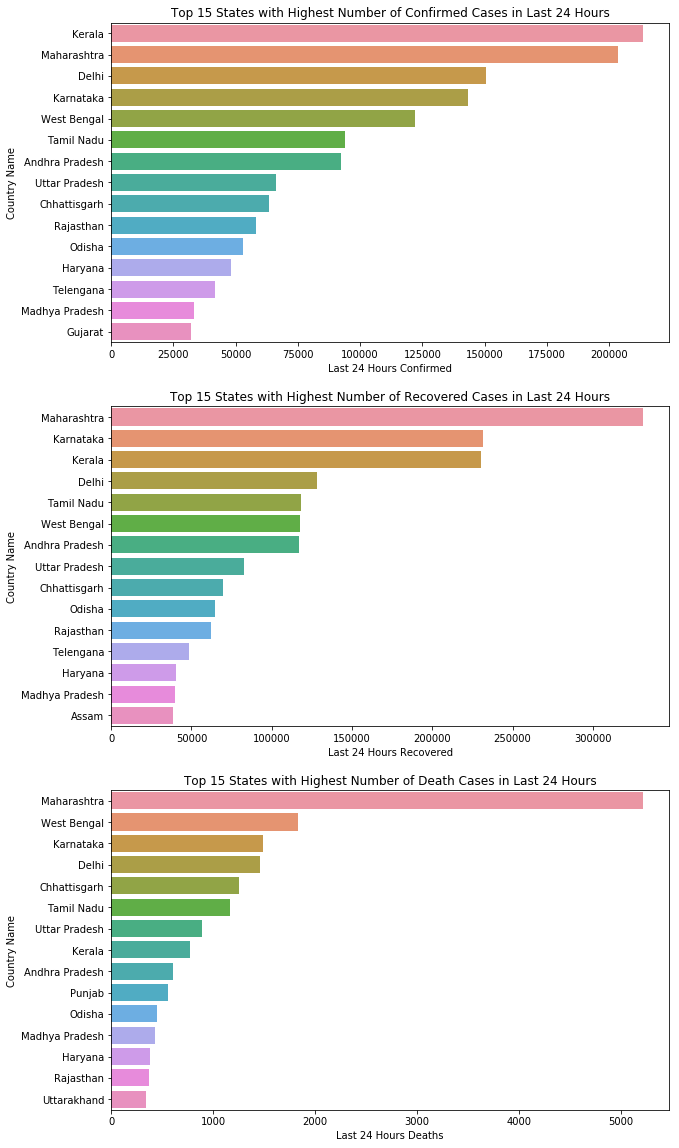

In [96]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_cured_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 States with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_15_cured_24hr["Last 24 Hours Recovered"],y=Top_15_cured_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 States with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 States with Highest Number of Death Cases in Last 24 Hours")

## Proportion of Countries in Confirmed, Recovered and Death Cases

In [97]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise["Cured"].iloc[-1]-datewise["Cured"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2]))*100

In [98]:
# Proportion of Cases in Last 24 hours
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
5,Kerala,13.657414,12.030052,4.048284
0,Maharashtra,13.023530,17.267651,27.468241
6,Delhi,9.635290,6.690207,7.690686
1,Karnataka,9.178011,12.077783,7.838279
7,West Bengal,7.815001,6.142415,9.646302
3,Tamil Nadu,6.014157,6.171262,6.130410
2,Andhra Pradesh,5.900684,6.104751,3.183807
4,Uttar Pradesh,4.233141,4.316717,4.675557
13,Chhattisgarh,4.064980,3.621295,6.610089
11,Rajasthan,3.716248,3.242050,1.945074


Text(0.5, 1.0, 'Top 15 states as per Number of Death Cases')

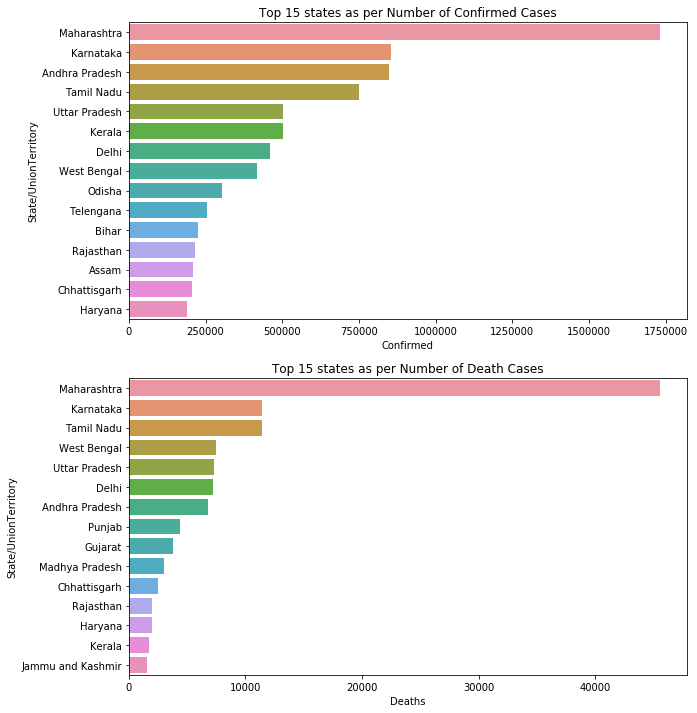

In [99]:
# Top countries as per Confirmed and Death Cases
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 states as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 states as per Number of Death Cases")

Text(0.5, 1.0, 'Top 15 States with Most Number of Closed Cases')

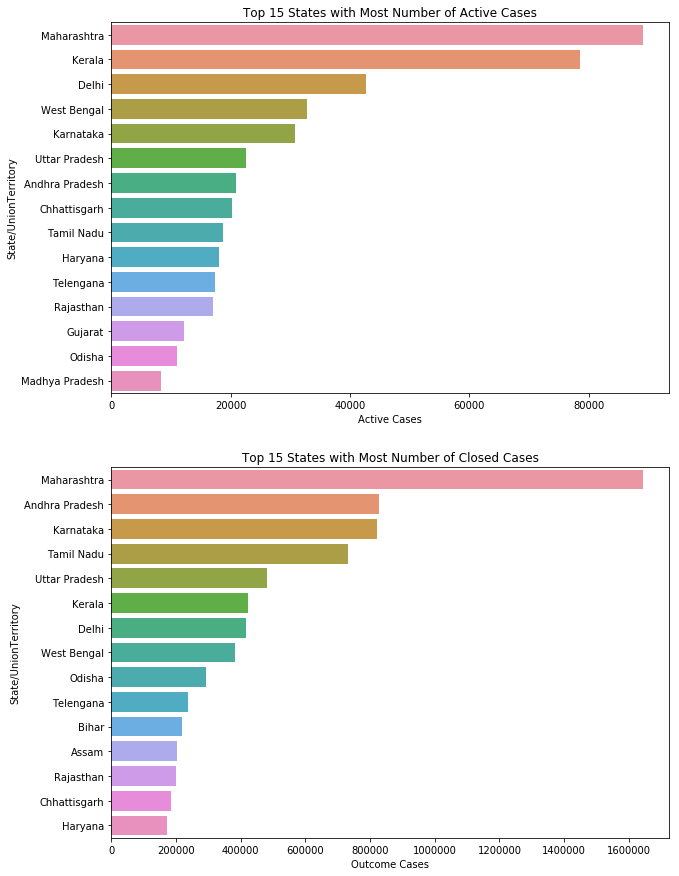

In [100]:
# Top countries with most number of Active and Closed Cases
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Cured"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Cured"]+countrywise["Deaths"])
top_15_active=countrywise.sort_values(["Active Cases"],ascending=False).head(15)
top_15_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_15_active["Active Cases"],y=top_15_active.index,ax=ax1)
sns.barplot(x=top_15_outcome["Outcome Cases"],y=top_15_outcome.index,ax=ax2)
ax1.set_title("Top 15 States with Most Number of Active Cases")
ax2.set_title("Top 15 States with Most Number of Closed Cases")

## Prediction using Machine Learning Models

### In Prediction, we will be focusing only on two Regression Models
<h4>
1. Linear Regression
2. Polynomial Regression</h4>

In [101]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [102]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

## Linear Regression for Prediction of Confirmed Cases

In [103]:
lin_reg=LinearRegression(normalize=True)

In [104]:
# Traiing our Model
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(normalize=True)

In [105]:
# Testing our Model
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [106]:
# Accuracy
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  4223062.624698699


In [107]:
# plt for Linear Regression Model
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases - Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

## Polynomial Regression for Prediction of Confirmed Cases

In [108]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [109]:
poly = PolynomialFeatures(degree = 8)

In [110]:
# Training and Validation
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [111]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

In [112]:
# Accuracy
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  11081637.9510988


In [113]:
# plt for Polynomial Regression Model
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases - Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [114]:
new_date=[]
new_prediction_lr=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])

In [115]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [116]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction"])
model_predictions.head(10)

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction
0,2020-12-12,5623669.336953,20753625.988409
1,2020-12-13,5641096.965402,21745898.719915
2,2020-12-14,5658524.593852,22788419.621641
3,2020-12-15,5675952.222301,23883096.946371
4,2020-12-16,5693379.850750,25031889.809614
5,2020-12-17,5710807.479200,26236809.086088
6,2020-12-18,5728235.107649,27499918.315397
7,2020-12-19,5745662.736098,28823334.616812
8,2020-12-20,5763090.364547,30209229.612852
9,2020-12-21,5780517.992997,31659830.362173


In [117]:
# Comparing both Models
model_names=["Linear Regression","Polynomial Regression"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
0,Linear Regression,4223062.624699
1,Polynomial Regression,11081637.951099


### ARIMA Model

In [118]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [119]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9447.378, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9448.133, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9450.130, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9445.034, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9448.149, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9450.126, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9432.166, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9419.077, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9449.926, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9431.102, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9432.536, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9421.614, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9446.213, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9426.190, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9426.714, Time=0.28 sec
Total fit 

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

In [120]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [121]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))


Root Mean Square Error for ARIMA Model:  5339359.554930063


In [122]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [123]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,ARIMA Model Prediction
0,2020-12-12,5623669.336953,20753625.988409,8685593.408034
1,2020-12-13,5641096.965402,21745898.719915,8736296.306206
2,2020-12-14,5658524.593852,22788419.621641,8787009.080801
3,2020-12-15,5675952.222301,23883096.946371,8837727.103104
4,2020-12-16,5693379.850750,25031889.809614,8888447.913706


### SARIMA Model

In [124]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=9450.257, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9447.378, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9449.274, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=9449.247, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9445.463, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=9448.257, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=9448.254, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=9448.149, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9448.133, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=9450.126, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 0.581 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [125]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [126]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  5893080.436812934


In [127]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [128]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-12-12,5623669.336953,20753625.988409,8685593.408034,9177840.000000
1,2020-12-13,5641096.965402,21745898.719915,8736296.306206,9177840.000000
2,2020-12-14,5658524.593852,22788419.621641,8787009.080801,9177840.000000
3,2020-12-15,5675952.222301,23883096.946371,8837727.103104,9177840.000000
4,2020-12-16,5693379.850750,25031889.809614,8888447.913706,9177840.000000
